Download Dataset

**Data Description**
The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat)

In [1]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2024-07-12 07:30:44--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.62.161.112, 2600:1408:c400:1680::317f, 2600:1408:c400:168a::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.62.161.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.1’

kagglecatsanddogs_5 100%[===================>] 786.67M   120MB/s    in 9.4s    

2024-07-12 07:30:54 (83.8 MB/s) - ‘kagglecatsanddogs_5340.zip.1’ saved [824887076/824887076]



Unzip the file

In [2]:
!unzip kagglecatsanddogs_5340.zip.1

Archive:  kagglecatsanddogs_5340.zip.1
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Necessary Modules Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
from tqdm import tqdm
import warnings
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

Create DataFrame For Input and Output

In [4]:
input_paths = []
labels = []

for class_name in ["Cat", "Dog"]:
  for filename in tqdm(os.listdir(f"PetImages/{class_name}")):
    input_paths.append(f"PetImages/{class_name}/{filename}")
    labels.append(0 if class_name == "Cat" else 1)

print(input_paths[0], labels[0])

100%|██████████| 12501/12501 [00:00<00:00, 813028.09it/s]

PetImages/Cat/11908.jpg 0


In [5]:
df=pd.DataFrame()
df['input_paths']=input_paths
df['labels']=labels
df=df.sample(frac=1).reset_index(drop=True)
df.head()

,input_paths,labels
0,PetImages/Dog/9730.jpg,1
1,PetImages/Dog/7906.jpg,1
2,PetImages/Cat/7945.jpg,0
3,PetImages/Cat/9878.jpg,0
4,PetImages/Dog/3420.jpg,1


In [6]:
for i in df['input_paths']:
    if '.jpg' not in i:
        print(i)

PetImages/Dog/Thumbs.db
PetImages/Cat/Thumbs.db


In [7]:
import PIL
l = []
for image in df['input_paths']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l


['PetImages/Dog/11702.jpg',
 'PetImages/Dog/Thumbs.db',
 'PetImages/Cat/Thumbs.db',
 'PetImages/Cat/666.jpg']

In [8]:
# delete db files
df = df[df['input_paths']!='PetImages/Dog/Thumbs.db']
df = df[df['input_paths']!='PetImages/Cat/Thumbs.db']
df = df[df['input_paths']!='PetImages/Cat/666.jpg']
df = df[df['input_paths']!='PetImages/Dog/11702.jpg']
len(df)

24998

In [9]:
print(df['labels'].value_counts())

labels
1    12499
0    12499
Name: count, dtype: int64


##Exploratory Data Analysis

In [10]:
dog_images = df[df['labels'] == 1]['input_paths']
if dog_images.empty:
    print("No dog images found in the dataset.")
else:
    dog_images = dog_images.sample(25)
    # ... rest of the code to display images
# Sample 25 random images of dogs
#dog_images = df[df['labels'] == 1]['input_paths']

# Display the images in a 5x5 grid
plt.figure(figsize=(25, 25))
for i, file in enumerate(dog_images):
  plt.subplot(5, 5, i + 1)
  img = load_img(file)
  plt.imshow(img)
  plt.title('Dog')
  plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

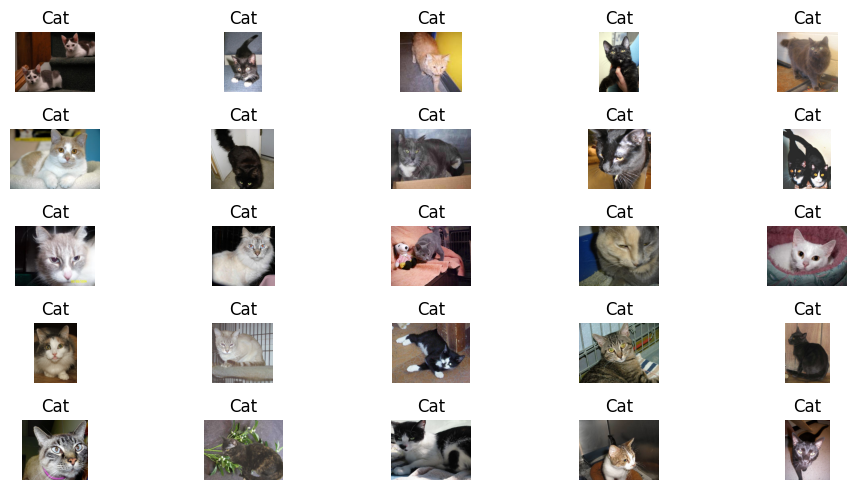

In [11]:
# Sample 25 random images of cats
cat_images = df[df['labels'] == 0]['input_paths'].sample(25)

# Display the images in a 5x5 grid
plt.figure(figsize=(10, 5))
for i, file in enumerate(cat_images):
  plt.subplot(5, 5, i + 1)
  img = load_img(file)
  plt.imshow(img)
  plt.title('Cat')
  plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
#import seaborn as sns
#sns.countplot(df['labels'])

In [13]:
df['labels'] = df['labels'].astype('str')

In [14]:
df.head()

,input_paths,labels
0,PetImages/Dog/9730.jpg,1
1,PetImages/Dog/7906.jpg,1
2,PetImages/Cat/7945.jpg,0
3,PetImages/Cat/9878.jpg,0
4,PetImages/Dog/3420.jpg,1


In [15]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)


In [16]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='input_paths',
    y_col='labels',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='input_paths',
    y_col='labels',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


##Model Creation

In [17]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)), # Add another MaxPooling layer
    Flatten(), # Flatten the output for the dense layers
    Dense(512, activation='relu'), # Add a dense layer
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

In [19]:
from keras.callbacks import ModelCheckpoint

# Define a checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Fit the model with the checkpoint callback
history = model.fit(
    train_iterator,
    epochs=10,
    validation_data=val_iterator,
    callbacks=[checkpoint]
)

Epoch 1/10
40/40 [==============================] - 449s 11s/step - loss: 0.7113 - accuracy: 0.5281 - val_loss: 0.6566 - val_accuracy: 0.6274
Epoch 2/10
40/40 [==============================] - 453s 11s/step - loss: 0.6297 - accuracy: 0.6505 - val_loss: 0.5679 - val_accuracy: 0.7100
Epoch 3/10
40/40 [==============================] - 498s 12s/step - loss: 0.5743 - accuracy: 0.6991 - val_loss: 0.5351 - val_accuracy: 0.7262
Epoch 4/10
40/40 [==============================] - 499s 12s/step - loss: 0.5480 - accuracy: 0.7211 - val_loss: 0.5103 - val_accuracy: 0.7556
Epoch 5/10
40/40 [==============================] - 442s 11s/step - loss: 0.5215 - accuracy: 0.7423 - val_loss: 0.4916 - val_accuracy: 0.7648
Epoch 6/10
40/40 [==============================] - 449s 11s/step - loss: 0.4955 - accuracy: 0.7570 - val_loss: 0.4768 - val_accuracy: 0.7776
Epoch 7/10
40/40 [==============================] - 440s 11s/step - loss: 0.4809 - accuracy: 0.7653 - val_loss: 0.4507 - val_accuracy: 0.7928
Epoch 

##Visualize of Results

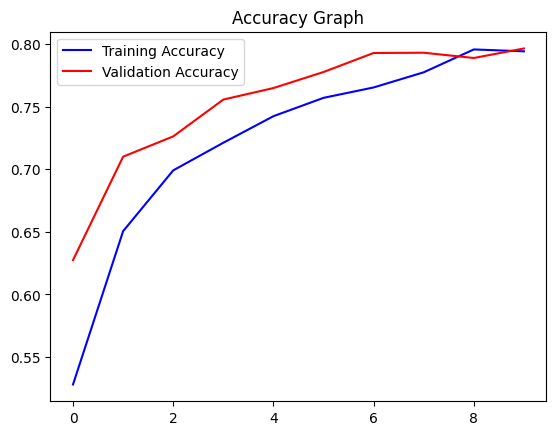

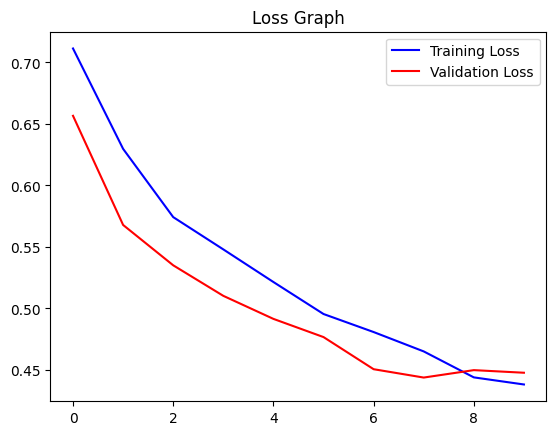

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Test with Real Image

1/1 [==============================] - 0s 34ms/step
Dog


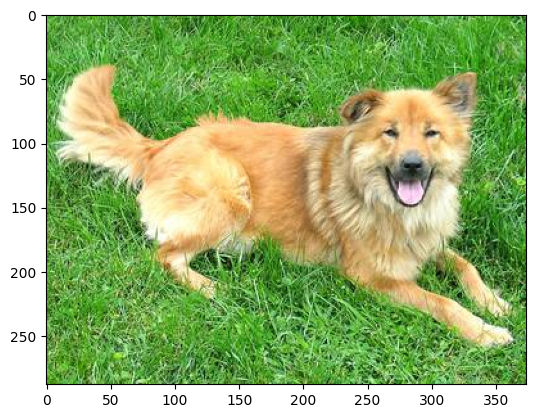

In [24]:
from PIL import UnidentifiedImageError
image_path = "/content/4.jpg"
try:
    img = load_img(image_path, target_size=(128, 128))
    img = np.array(img)
    img = img / 255.0
    img = img.reshape(1, 128, 128, 3)
    pred = model.predict(img)
    if pred[0] > 0.5:
        label = 'Dog'
    else:
        label = 'Cat'
    print(label)
except UnidentifiedImageError:
    print(f"Error: Unable to load image from {image_path}")


from keras.preprocessing.image import load_img
img = load_img('/content/4.jpg') # Replace with the actual path
plt.imshow(img)
plt.show()